# Fashion MNIST Generative Adversarial Network (GAN)

[Мой блог](https://tiendil.org)

[Пост об этом notebook](https://tiendil.org/fashion-mnist-gan)

[Все публичные notebooks](https://github.com/Tiendil/public-jupyter-notebooks)

Учебная реализация [GAN](https://en.wikipedia.org/wiki/Generative_adversarial_network) на данных [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist).

На основе следующих материалов:

- https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/
- https://www.tensorflow.org/tutorials/generative/dcgan
- https://keras.io/examples/generative/dcgan_overriding_train_step/

Сходу у меня не получилось нагуглись «красивое» решение. Поэтому тут будет композиция разных уроков. На мой взгляд, получилось более идиоматично.

Про GAN лучше почитать по ссылке выше. Краткая суть:

- Тренируются две сети: generator & discriminator.
- Генератор учится создавать картинки из шума.
- Дискриминатор учится отличать поддельные картинки от настоящих.
- Ошибка дискриминатора определяется качеством предсказания фейковости изображения.
- Ошибка генератора определяется качеством обмана дискриминатора. 

Подробнее про ошибки будет далее.

Если правильно подобрать топологии сетей и параметры обучения, то в итоге генератор научается создавать картинки неотличимые от оригинальных. ??????. Profit.

## Подготовка

Notebook запускался в кастомизированном docker контейнере.

Подробнее про мои злоключения с настройкой tensorflow + CUDA можно почитать в блоге: [нельзя просто так взять и запустить DL](https://tiendil.org/you-cant-just-take-and-run-dl).

Официальная документация о [запуске tensorflow через docker](https://www.tensorflow.org/install/docker).

Dockerfile: 

```
FROM tensorflow/tensorflow:2.5.0-gpu-jupyter

RUN apt-get update && apt-get install -y graphviz

RUN pip install --upgrade pip

COPY requirements.txt ./

RUN pip install -r ./requirements.txt

```

requirements.txt:
```
pandas==1.1.5
kaggle==1.5.12
pydot==1.4.2  # requeired by tensorflow to visualize models
livelossplot==0.5.4  # required to plot loss while training
albumentations==1.0.3  # augument image data
jupyter-beeper==1.0.3
```

## Инициализация

Уже без комментариев, подробнее рассказано в [предыдущих notebooks](https://github.com/Tiendil/public-jupyter-notebooks).

In [1]:
import os
import random
import logging
import datetime

import PIL
import PIL.Image

import jupyter_beeper

from IPython.display import display, Markdown, Image
import ipywidgets as ipw

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

from livelossplot import PlotLossesKerasTF

import cv2 

logging.getLogger().setLevel(logging.WARNING)

tf.get_logger().setLevel(logging.WARNING)
tf.autograph.set_verbosity(1)

old_settings = np.seterr('raise')

gpus = tf.config.list_physical_devices("GPU")

display(Markdown(f'Num GPUs Available: {len(gpus)}'))

if not gpus:
    raise RuntimeError('No GPUs found, learning process will be too slow. In Google Colab set runtime type — GPU.')
    
display(Markdown(f'Eager mode: {tf.executing_eagerly()}'))

tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs Available: 1

Eager mode: True

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.keras.backend.clear_session()

RNG = np.random.default_rng()

## Вспомогательные функции

Можно пролистать. Смотрите при необходимости.

In [3]:
def split_dataset(data, *parts, cache):
    data_size = data.cardinality()
    assert data_size == sum(parts), \
           f"dataset size must be equal to sum of parts: {data_size} != sum{parts}"
    
    result = []
    
    for part in parts:
        data_part = data.take(part)
        
        if cache:
            data_part = data_part.cache()
        
        result.append(data_part)
        
        data = data.skip(part)
        
    return result


def normalizer(minimum, maximum): 
    def normalize_dataset(x):
        return (x - minimum) / (maximum - minimum)
    return normalize_dataset


def display_model(model, name):
    filename = f'/tmp/tmp_model_schema_{name}.png'
    
    keras.utils.plot_model(model, 
                           show_shapes=True, 
                           show_layer_names=True, 
                           show_dtype=True,
                           expand_nested=True,
                           to_file=filename)
    display(Image(filename))
    

class LayersNameGenerator:
    __slots__ = ('prefix', 'number')
    
    _version = 0
    
    def __init__(self, prefix):
        self.prefix = prefix
        self.number = 0
        
        self.__class__._version += 1
        
    def __call__(self, type_name, name=None):
        self.number += 1
        
        if name is None:
            name = str(self.number)
            
        return f'{self.prefix}.{self._version}-{type_name}.{name}'   
    

def display_examples(examples_number=1, 
                     data_number=1, 
                     image_getter=None, 
                     label_getter='',
                     figsize=(16, 16),
                     subplot=None,
                     cmap=plt.get_cmap('gray')):

    if image_getter is None:
        raise ValueError('image_getter must be an image or a collable')
        
    if not callable(image_getter):
        image_value = image_getter
        image_getter = lambda j: image_value
        
    if not callable(label_getter):
        label_value = label_getter
        label_getter = lambda j: label_value

    examples_number = min(examples_number, data_number)
                     
    if subplot is None:
        subplot = (1, examples_number)
    
    plt.figure(figsize=figsize)
    
    if examples_number < data_number:
        choices = RNG.choice(data_number, examples_number, replace=False)
    else:
        choices = list(range(data_number))
        
    for i, j in enumerate(choices):
        plt.subplot(*subplot, i+1)
        plt.imshow(image_getter(j), cmap=cmap)
        plt.title(label_getter(j))

    plt.show()
        
        
def display_memory_stats():
    stats = tf.config.experimental.get_memory_info('GPU:0')
    message = f'''
    current: {stats["current"]/1024/1024}Mb
    peak: {stats["peak"]/1024/1024}Mb
    '''
    display(Markdown(message))
    
    
def make_report(history, main, metrics):  
    groups = {'main': {}}
    
    for key in history.history.keys():
        if key in ('loss', 'val_loss', 'accuracy', 'val_accuracy'):
            if key.startswith('val_'):
                metric = key
            else:
                metric = f'train_{key}'
                
            groups['main'][metric] = history.history[key][-1]
            continue
            
        if not any(key.endswith(f'_{metric}') for metric in metrics):
            continue
            
        group, metric = key.rsplit('_', 1)
              
        validation = False
        
        if group.startswith('val_'):
            group = group[4:]
            validation = True
        
        if group not in groups:
            groups[group] = {}
            
        if validation:
            metric = f'val_{metric}'
        else:
            metric = f'train_{metric}'
            
        groups[group][metric] = history.history[key][-1]
        
    lines = []
    
    for group, group_metrics in groups.items():
        lines.append(f'**{group}:**')
        lines.append(f'```')
        
        for name, value in sorted(group_metrics.items()):
            if name in ('accuracy', 'val_accuracy', 'train_accuracy'):
                lines.append(f'  {name}: {value:.4%} ({value})')
            else:
                lines.append(f'  {name}: {value}')
            
        lines.append(f'```')
        
    train_loss = groups[main]['train_loss']
    val_loss = groups[main].get('val_loss')
    val_accuracy = groups[main].get('val_accuracy')
        
    history.history[key][-1]
    
    if val_loss is None:
        description = f'train_loss: {train_loss:.4};'
    else:
        description = f'train_loss: {train_loss:.4}; val_loss: {val_loss:.4}; val_acc: {val_accuracy:.4%}'
    
    lines.append(f'**description:** {description}')
            
    return '\n\n'.join(lines), description


def crope_layer(input, expected_shape, names):
    raw_shape = input.get_shape()
    
    if raw_shape == (None, *expected_shape):
        outputs = input
    else:
        dy = raw_shape[1] - expected_shape[0]
        dx = raw_shape[2] - expected_shape[1]
        
        x1 = dx // 2
        x2 = dx - x1
        
        y1 = dy // 2
        y2 = dy - y1
        
        outputs = layers.Cropping2D(cropping=((y1, y2), (x1, x2)), 
                                    name=names('Cropping2D'))(input)
        
    return outputs


def neurons_in_shape(shape):
    input_n = 1
    
    for n in shape:
        if n is not None:
            input_n *= n
            
    return input_n


def form_images_map(h, w, images, channels, scale=1):
    map_image = np.empty((SPRITE_SIZE*h, SPRITE_SIZE*w, channels), dtype=np.float32)
    
    for i in range(h):
        y_1 = i * SPRITE_SIZE
        
        for j in range(w):
            sprite = images[i*w+j]       
            
            x_1 = j * SPRITE_SIZE

            map_image[y_1:y_1+SPRITE_SIZE, x_1:x_1+SPRITE_SIZE, :] = sprite
            
    if channels == 1:
        mode = 'L'
        map_image = np.squeeze(map_image)
    elif channels == 3:
        mode = 'RGB'
    else:
        raise ValueError(f'Unexpected channels value {channels}')
        
    if scale != 1:
        width, height = w * SPRITE_SIZE, h * SPRITE_SIZE
        map_image = cv2.resize(map_image, dsize=(width * scale, height * scale), interpolation=cv2.INTER_NEAREST)
           
    image = PIL.Image.fromarray((map_image * 255).astype(np.int8), mode)
   
    return image

## Получение данных

In [4]:
# получаем картинки одежды средствами TensorFlow
(TRAIN_IMAGES, TRAIN_LABELS), (TEST_IMAGES, TEST_LABELS) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
# константы, описывающие данные

CHANNELS = 1
SPRITE_SIZE = 28
SPRITE_SHAPE = (SPRITE_SIZE, SPRITE_SIZE, CHANNELS)

full data shape: <CacheDataset shapes: (28, 28, 1), types: tf.float32>

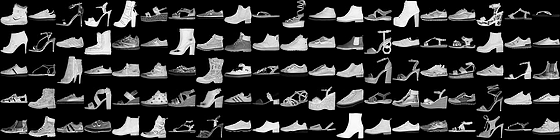

In [6]:
# Подготавливаем данные. Для GAN нам нужны только картинки.

def transform(images):
    images = (images / 255.0).astype(np.float32)
    images = np.expand_dims(images, axis=-1)
    return images


def filter_by_class(images, labels, classes):
    _images = tf.data.Dataset.from_tensor_slices(transform(images))
    _labels = tf.data.Dataset.from_tensor_slices(labels)
    
    d = tf.data.Dataset.zip((_images, _labels))
    d = d.filter(lambda i, l: tf.reduce_any(tf.equal(classes, l)))
    d = d.map(lambda i, l: i)
    
    return d


# Обучаться будем только на изображениях обуви:
#
# - сеть будет учиться быстрее;
# - результат будет лучше;
# - будет проще, интереснее играться с работой обученной сети.
#
# Впрочем, эта реализация нормально учится и на всех изображениях.

_classes = tf.constant((5, 7, 9), tf.uint8)

_train = filter_by_class(TRAIN_IMAGES, TRAIN_LABELS, _classes)
_test = filter_by_class(TEST_IMAGES, TEST_LABELS, _classes)

DATA = _train.concatenate(_test).cache()

# В некоторых местах нам потребуется знать размер обучающей выборки.
# Получать его таким образом — плохое решение, но на таких объёмах данных оно работает.
DATA_NUMBER = len(list(DATA))

display(Markdown(f'full data shape: {DATA}'))

# Визуально проверяем, что отобрали нужные классы
data = [image for image in DATA.take(100).as_numpy_iterator()]
form_images_map(5, 20, data, scale=1, channels=CHANNELS)

## Конструируем модель

По-сути, GAN — это три сети:

- Generator.
- Discriminator.
- GAN — объединение двух предыдущих.

Сам GAN можно не оформлять отдельной сетью, достаточно правильно описать взаимодействие генератора и дискриминатора при обучения. Но, поскольку они учатся совместно, как одно целое, я вижу логичным работать с ними как с единой сетью.

Поэтому мы отдельно создадим генератор с дискриминатором, после чего опишем класс сети, объединяющий их в единое целое.

### Обучение GAN

Обучение генератора и дискриминатора, само собой, происходит на основе функций ошибок. Функции каждой сети оценивают качество бинарной классификации входных данных, на фейковые и реальные. Обычно для этого используют [Binary Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy).

Дискриминатор на вход получает часть реальных изображений и часть созданных генератором. Поскольку класс каждого изображения мы знаем, мы можем легко определить ошибку дискриминатора.

Ошибку же генератора посчитать немного сложнее — качество его работы определяется дискриминатором. Чем хуже результат выдаёт дискриминатор на картинках генератора, тем лучше работает генератор. Поэтому мы скармиливаем дискриминатору созданные изображения с отметкой того, что они реальные (относятся к классу реальных), ошибка дискриминатора на таких данных и будет ошибкой генератора.

### Синхронизация сетей

Если генератор и дискриминатор будут учиться с разной скоростью или иметь разный потенциал выучиваемости, то они не смогут обучаться синхронно. Либо генератор превзойдёт дискриминатор и будет душить его тривиальными фейками, либо дискриминатор найдёт элементарный способ отличать подделки, который генератор не сможет обойти. 

Поэтому очень рекомендую при экспериментах с GAN сначала запускать что-нибудь очень простое, но работающее. И только после этого усложнять и экспериментировать. Не будьте как я :-)

Эти же соображения предполагают визуализацию результатов обучения сети. **Убедитесь, что она корректно работает перед экспериментами.** Иначе можете как я сутки отлаживать работающую сеть с неработающей визуализацией.

### Метрики

У нас есть две конкурирующие сети, которые учатся на результатах работы друг друга. Такое обучение, потенциально, может происходить бесконечно. 

Поэтому сходу не ясно какой критерий остановки использовать и на какие метрики смотреть, чтобы анализировать ход обучения.

На сколько я понял, по крайней мере для простых случаев качество обучения GAN оценивают визуально: видит человек косяки на выходе генератора или не видит. Альтернативой может быть либо использование другой, предобученной сети, либо метаанализ метрик. Ни в ту ни в другую сторону я не смотрел.

Касательно анализа самих метрик, есть одна эвристика, которую можно применить сразу в двух местах. 

Поскольку сети конкурируют, обучаются совместно и на одних данных, мы можем ожидать, что их ошибки будут стабильны. Утрируя, если генератор и дискриминатор обучаются с одинаковой скоростью из одного состояния, то их ошибки не должны изменяться, так как на любое улучшение генератора последует соответствующее улучшение дискриминатора и наоборот.

Отсюда можно вывести метаметрики, которые позволяют оценить стабильность обучения GAN:

- Отношение ошибки генератора к ошибке диксриминатора должно колебаться около единицы. Конечно, если их функции ошибок совпадают.
- Отношение ошибки дискриминатора на реальных данных к ошибке дискриминатора на фейковых данных должно колебаться около единицы.

Если любое из этих отношений сильно отклоняется от единицы, значит GAN обучается неравномерно и могут возникнуть проблемы. В то же время необходимо помнить, что нейронные сети — сложная штука, и отклонения могут быть. Иногда даже большие. Главное чтобы GAN восстанавливался после них.

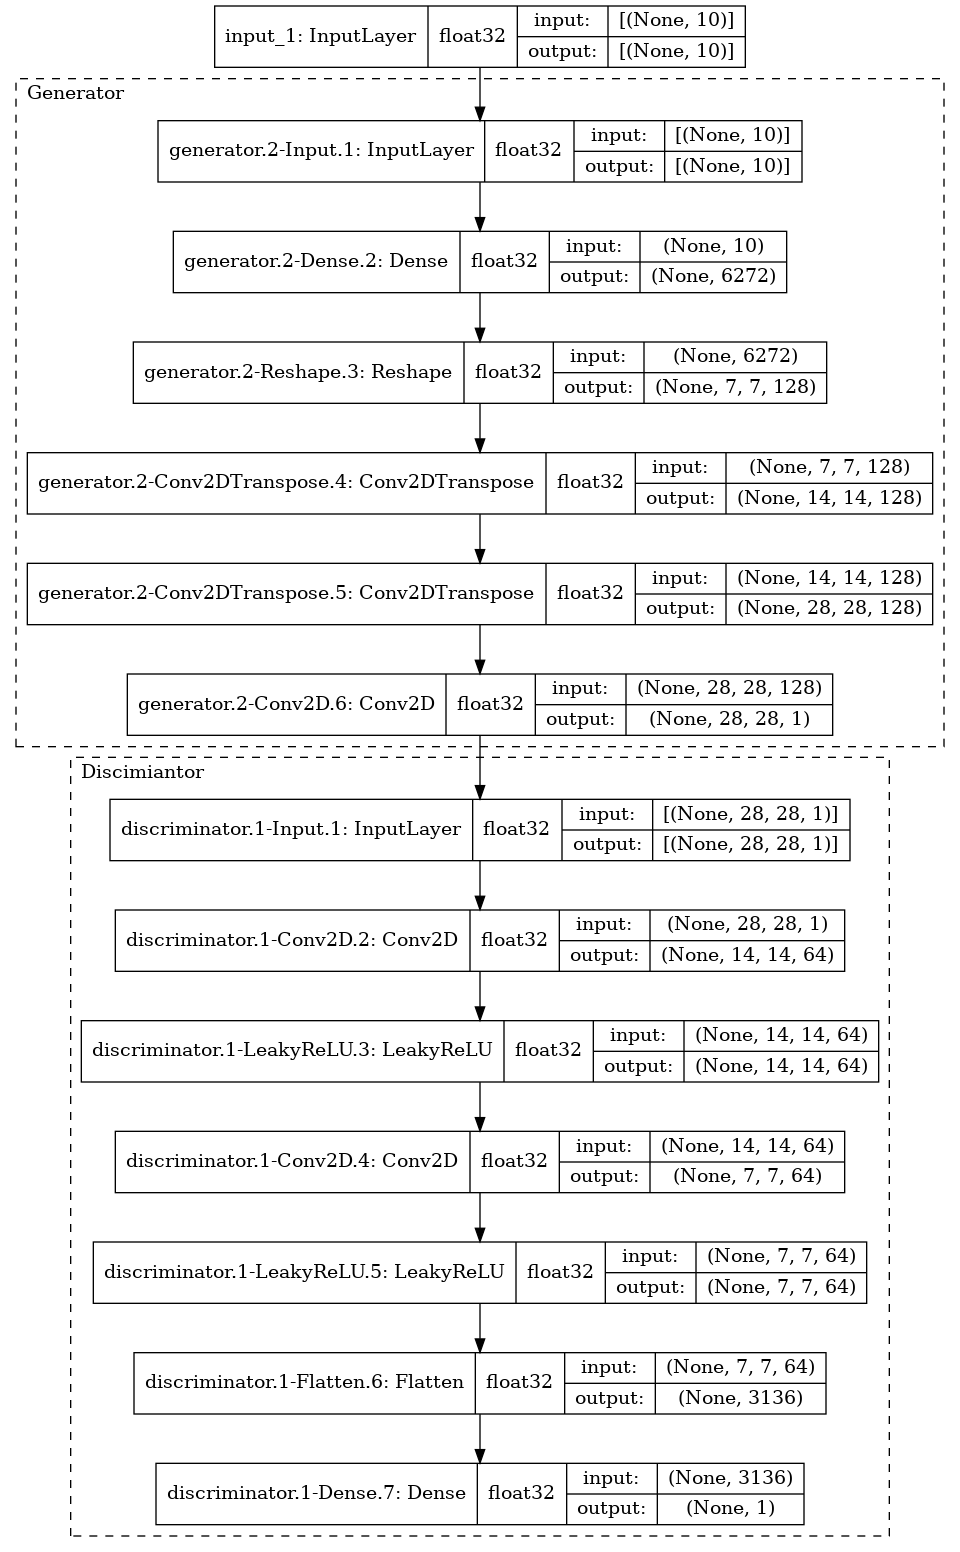

In [7]:
def construct_discriminator():
           
    names = LayersNameGenerator('discriminator')
          
    inputs = keras.Input(shape=SPRITE_SHAPE, name=names('Input'))
    
    branch = inputs
    
    n = 64
       
    branch = layers.Conv2D(n, 4, 2, padding='same', name=names('Conv2D'))(branch)
    branch = layers.LeakyReLU(alpha=0.2, name=names('LeakyReLU'))(branch)
    
    branch = layers.Conv2D(n, 4, 2, padding='same', name=names('Conv2D'))(branch)
    branch = layers.LeakyReLU(alpha=0.2, name=names('LeakyReLU'))(branch)
    
    branch = layers.Flatten(name=names('Flatten'))(branch)
        
    branch = layers.Dense(1, activation="sigmoid", name=names('Dense'))(branch)
    
    outputs = branch
    
    return keras.Model(inputs=inputs, outputs=outputs, name='Discimiantor')


def construct_generator(code_n):
    
    names = LayersNameGenerator('generator')
       
    inputs = keras.Input(shape=(code_n,), name=names('Input'))    
     
    branch = inputs
        
    n = 128
    
    branch = layers.Dense(7 * 7 * n, activation='elu', name=names('Dense'))(branch)
    
    branch = layers.Reshape((7, 7, n), name=names('Reshape'))(branch)
    
    branch = layers.Conv2DTranspose(n, 4, 2, activation='relu', padding='same', name=names('Conv2DTranspose'))(branch)
    
    branch = layers.Conv2DTranspose(n, 4, 2, activation='relu', padding='same', name=names('Conv2DTranspose'))(branch)
       
    branch = layers.Conv2D(CHANNELS, 7, activation="sigmoid", padding='same', name=names('Conv2D'))(branch)
    
    outputs = branch

    
    return keras.Model(inputs=inputs, outputs=outputs, name='Generator')


# Вспомогательный класс для сбора метрик GAN.
# Кроме трёх базовых метрик:
# - ошибка дискриминатора на реальных данных;
# - ошибка дискриминатора на фейковых данных;
# - ошибка генератора;
# Поддерживает две производные метрики:
# - отношение ошибок дискриминатора на реальных и фейковых данных;
# - отношение ошибок дискриминатора на фековых данных и генератора.
class GANMetrics:
    
    def __init__(self):
        self._define('discriminator_real_loss')
        self._define('discriminator_fake_loss')
        self._define('generator_loss')
        
        self._define('discriminator_real_vs_fake_loss')
        self._define('discriminator_vs_generator_loss')
        
    def _define(self, name):
        setattr(self, name, keras.metrics.Mean(name=name))
        
    def update_state(self, d_real_loss, d_fake_loss, g_loss):
        self.discriminator_real_loss.update_state(d_real_loss)
        self.discriminator_fake_loss.update_state(d_fake_loss)
        self.generator_loss.update_state(g_loss)
        
        self.discriminator_real_vs_fake_loss.update_state(tf.math.divide_no_nan(d_real_loss, d_fake_loss))
        self.discriminator_vs_generator_loss.update_state(tf.math.divide_no_nan(d_fake_loss, g_loss))
        
    def result(self):
        return {"discriminator_real_loss": self.discriminator_real_loss.result(),
                "discriminator_fake_loss": self.discriminator_fake_loss.result(),
                "generator_loss": self.generator_loss.result(),
               
                "discriminator_real_vs_fake_loss": self.discriminator_real_vs_fake_loss.result(),
                "discriminator_vs_generator_loss": self.discriminator_vs_generator_loss.result()}
    
    def list(self):
        return [self.discriminator_real_loss,
                self.discriminator_fake_loss,
                self.generator_loss,
                self.discriminator_real_vs_fake_loss,
                self.discriminator_vs_generator_loss]
         
    # Группы графиков для livelossplot
    def plotlosses_groups(self):
        return {'discriminator loss': ['discriminator_real_loss', 'discriminator_fake_loss'],
                'generator loss': ['generator_loss'],
                'relations': ['discriminator_real_vs_fake_loss', 'discriminator_vs_generator_loss']}
    
    # Короткие имена для графиков livelossplot
    def plotlosses_group_patterns(self):
        return ((r'^(discriminator_real_loss)(.*)', 'real'),
                (r'^(discriminator_fake_loss)(.*)', 'fake'),
                (r'^(generator_loss)(.*)', 'loss'),
                (r'^(discriminator_real_vs_fake_loss)(.*)', 'real / fake'),
                (r'^(discriminator_vs_generator_loss)(.*)', 'disciminator / generator'),)
    

# Класс сети, объединяющей генератор и дискриминатор в GAN.
# Делаем отдельный класс, так как нам необходимо переопределить шаг обучения.
# Плюс, оформление в виде класса позволяет проще визуализировать сеть.
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, **kwargs):
        
        inputs = layers.Input(shape=latent_dim)
        
        super().__init__(inputs=inputs, 
                         outputs=discriminator(generator(inputs)), 
                         **kwargs)
        
        self.discriminator = discriminator
        self.generator = generator
        
        self.latent_dim = latent_dim
        
        self.batch_size = None
        self.real_labels = None
        self.fake_labels = None

    def compile(self, batch_size):
        super().compile()
        self.custom_metrics = GANMetrics()
        
        self.batch_size = batch_size
        
        self.real_labels = tf.ones((self.batch_size, 1))
        self.fake_labels = tf.zeros((self.batch_size, 1))

    @property
    def metrics(self):
        return self.custom_metrics.list()
    
    def latent_vector(self, n):
        return tf.random.normal(shape=(n, self.latent_dim))  
            
    # Самый интересный метод — шаг обучения GAN.
    # В куче примеров генератор и дискриминатор учатся отдельно и даже на разных данных.
    # Такой лобовой подход имеет право на жизнь, но он точно не оптимален. 
    # Он приводит к генерации большого количества лишних данных и просто к лишним операциям над памятью.
    # Поэтому мы будем учить обе сети в один проход.
    @tf.function    
    def train_step(self, real_images):        
        # Генерируем шум для генератора, количество примеров берём равным количеству входных данных.
        random_latent_vectors = self.latent_vector(self.batch_size)
        
        # Генератор и дискриминатор должны учиться на разных операциях.
        # Поэтому самостоятельно записываем операции для расчёта градиентов.
        # Указываем persistent=True. TensorFlow по-умолчанию чистит GradientTape после расчёта первого градиаента,
        # а нам надо рассчитывать два — по градиенту на сеть.
        try:
            with tf.GradientTape(persistent=True) as tape:
                # генерируем поддельные картинки
                fake_images = self.generator(random_latent_vectors)
            
                # оцениваем их дискриминатором
                fake_predictions = self.discriminator(fake_images)
            
                # рассчитываем ошибку генератора, предполагая что сгенерированные картинки реальны
                g_loss = self.discriminator.compiled_loss(self.real_labels, fake_predictions)
            
                # рассчитываем ошибку дискриминатора на фейковых картинках, зная, что они фейковые
                d_f_loss = self.discriminator.compiled_loss(self.fake_labels, fake_predictions)
            
                # получаем предсказания дискриминатора для реальных картинок
                real_predictions = self.discriminator(real_images)
            
                # рассчитываем ошибку дискриминатора для реальных картинок
                d_r_loss = self.discriminator.compiled_loss(self.real_labels, real_predictions)           
            
            # считаем градиент генератора и делаем шаг оптимизации
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.generator.optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
            # считаем градиент дискриминатора и делаем шаг оптимизации
            grads = tape.gradient((d_r_loss, d_f_loss), self.discriminator.trainable_weights)      
            self.discriminator.optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            
            # обновляем метрики
            self.custom_metrics.update_state(d_r_loss, d_f_loss, g_loss)
        
        finally:
            # Удаляем лог градиента
            del tape       

        return self.custom_metrics.result()


# Количество входов шума для генератора.
# 10 — очень малое значение! Я взял его, чтобы после обучения сети было проще с ней экспериментировать.
# По-хорошему, это значение надо установить в 100 или больше.
# Само собой, при большом количестве шума, сложно будет целенаправлено манипулировать сетью.
# Обойти эту проблему можно с использованием дополнительной autoencoder сети, 
# которая учится «сжимать» данные до множества признаков.
# Подход с autoencoder мне видится логичным и потому, что GAN использует входные данные всё-таки как шум,
# а не как признаки. В то же время autoencoder ориентирован на выделение признаков.
CODE_N = 10

# Создаём генератор, дискриминатор и объединяем их в GAN.
# Обратите внимание на кастомные параметры оптимизаторов. 
# Стандартные параметры TensorFlow плохо подходят для обучения GAN.

discriminator = construct_discriminator()
discriminator.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),          
                      loss=keras.losses.BinaryCrossentropy())

generator = construct_generator(CODE_N)
generator.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),          
                  loss=keras.losses.BinaryCrossentropy())
    
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=CODE_N, name='GAN')

display_model(gan, 'GAN')

Generator output

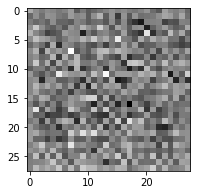

Discriminator output: [[0.502036]]

In [8]:
# Проверяем, что модель в принципе что-то считает
check_input = tf.constant(RNG.random((1, CODE_N)), shape=(1, CODE_N))

generator_output = gan.generator(check_input)

display(Markdown(f'Generator output'))

display_examples(image_getter=generator_output[0],
                 figsize=(3, 3))

discriminator_output = gan.discriminator(generator_output)

display(Markdown(f'Discriminator output: {discriminator_output}'))

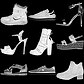

In [9]:
# Проверяем, что визуализатор работает на реальных данных
data = [image for image in DATA.take(9).as_numpy_iterator()]
form_images_map(3, 3, data, scale=1, channels=CHANNELS)

In [10]:
# Определяем собственный callback для model.fit, который будет:
# - отображать работу генератора каждую эпоху;
# - сохранять картинки на файловую систему.
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, w, h, images_directory, scale):
        self.w = w 
        self.h = h
        self.images_directory = images_directory
        self.scale = scale

    def on_epoch_end(self, epoch, logs=None):
        n = self.w * self.h
        
        random_latent_vectors = self.model.latent_vector(n) 
                
        generated_images = self.model.generator(random_latent_vectors).numpy()
        
        pil_world = form_images_map(self.h, self.w, generated_images, channels=CHANNELS, scale=self.scale)
        
        pil_world.save(f"{IMAGES_DIRECTORY}/generated_img_%04d.png" % (epoch,))
        
        display(pil_world)

In [11]:
# Задаём параметры обучения

# Сколько раз цикл обучения пройдёт по всем обучающим данным.
# Установите на свой вкус, 100 должно хватить, чтобу увидеть результат
EPOCHS = 100
BATCH_SIZE = 128

display(Markdown(f'batch size: {BATCH_SIZE}'))
display(Markdown(f'epochs: {EPOCHS}'))

batch size: 128

epochs: 100

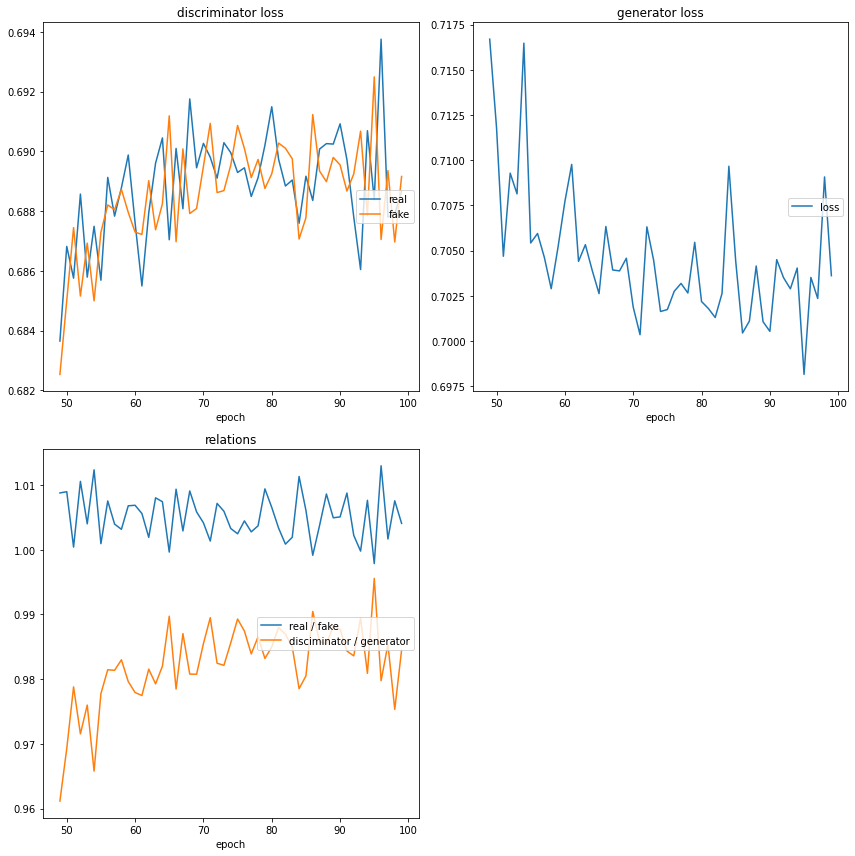

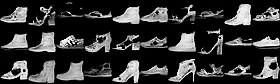

CPU times: user 11min 54s, sys: 17.2 s, total: 12min 11s
Wall time: 11min 27s


In [12]:
%%time

# каталог с результатами работы генератора
IMAGES_DIRECTORY = 'generated-images'

# создаём каталог с картинками и чистим его, если он заполнен
!mkdir -p $IMAGES_DIRECTORY
!rm $IMAGES_DIRECTORY/*

# Явно формируем dataset для скармливания сети во время обучения.
# Разбиваем на куски и говорим готовить их заранее.
data_for_train = DATA.shuffle(DATA_NUMBER).batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=10)

# Подготавливаем модель. 
gan.compile(batch_size=BATCH_SIZE)

# Запускаем обучение.
# Для PlotLossesKerasTF указываем дополнительную конфигурацию графиков.
# Для GANMonitor указываем параметры визуализации.
history = gan.fit(data_for_train,
                  epochs=EPOCHS,
                  callbacks=[PlotLossesKerasTF(from_step=-50,
                                               groups=gan.custom_metrics.plotlosses_groups(),
                                               group_patterns=gan.custom_metrics.plotlosses_group_patterns(),
                                               outputs=['MatplotlibPlot']),
                             GANMonitor(h=3, 
                                        w=10, 
                                        images_directory=IMAGES_DIRECTORY, 
                                        scale=1)])

In [13]:
# Гудим противным звуком, чтобы сообщить об окончании обучения
jupyter_beeper.Beeper().beep(frequency=330, secs=3, blocking=True)

In [14]:
# Поиграем с результатом

start_index = random.randint(0, DATA_NUMBER-1)

def zero_input():
    return tf.zeros((CODE_N,))

start_vector = gan.latent_vector(1)[0]

interact_args = {f'v_{i}': ipw.FloatSlider(min=-3.0, max=3.0, step=0.01, value=start_vector[i])
                 for i in range(CODE_N)}


@ipw.interact(**interact_args)
def generate_sprite(**kwargs):
    vector = zero_input().numpy()
    
    for i in range(CODE_N):
        vector[i] = kwargs[f'v_{i}']
        
    vector = vector.reshape((1, CODE_N))
        
    sprite = gan.generator(vector)[0].numpy()
       
    scale = 1
    
    sprite = cv2.resize(sprite, dsize=(SPRITE_SIZE*scale, SPRITE_SIZE*scale), interpolation=cv2.INTER_NEAREST)
    
    return PIL.Image.fromarray((sprite * 255).astype(np.uint8))

interactive(children=(FloatSlider(value=-1.982727289199829, description='v_0', max=3.0, min=-3.0, step=0.01), …